In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import os
import yaml
from google.cloud import aiplatform as vertex_ai

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
# Load configuration
CONFIG_PATH = "../configs/config.yaml"
with open(CONFIG_PATH, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Paths from configuration
PROJECT_ID = config['gcp']['project_id']
LOCATION = config['gcp']['location']
TENSORBOARD_NAME = f"projects/{PROJECT_ID}/locations/{LOCATION}/tensorboards/149744687610068992"


In [4]:
# Set up experiment tracking
vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket="gs://experiment_tracking_bucket",
    experiment="retail-experiment-autolog",
    experiment_tensorboard=vertex_ai.Tensorboard(TENSORBOARD_NAME)
)

In [5]:
# Set up BigQuery client
client = bigquery.Client(project="mlops-retail-quant")

# Query the data from BigQuery
query = """
SELECT * FROM `mlops-retail-quant.retail_dataset.raw_data_table`
"""
df = client.query(query).to_dataframe()

# Display the dataframe
df.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00+00:00,0.0,<NA>,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00+00:00,0.0,<NA>,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.dtypes

invoice_no                   object
stock_code                   object
description                  object
quantity                      Int64
invoice_date    datetime64[us, UTC]
unit_price                  float64
customer_id                   Int64
country                      object
dtype: object

In [8]:
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))

customer_id    135080
description      1454
dtype: int64


In [9]:
df.duplicated().sum()

5268

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   invoice_no    541909 non-null  object             
 1   stock_code    541909 non-null  object             
 2   description   540455 non-null  object             
 3   quantity      541909 non-null  Int64              
 4   invoice_date  541909 non-null  datetime64[us, UTC]
 5   unit_price    541909 non-null  float64            
 6   customer_id   406829 non-null  Int64              
 7   country       541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


### Data Cleaning

In [11]:
#Removing NaN's in Customer ID
print("Shape of df before removing NaN's CustomerID",df.shape)
df_v2 = df.dropna(subset="customer_id",axis=0)
print("Shape of df after removing NaN's CustomerID",df_v2.shape)

Shape of df before removing NaN's CustomerID (541909, 8)
Shape of df after removing NaN's CustomerID (406829, 8)


In [12]:
print("Missing values in each column after cleaning customerID :\n",df_v2.isnull().sum())

Missing values in each column after cleaning customerID :
 invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64


In [13]:
# after reading invoice_no starts with the 'c' means cancelled transaction
df_v3 = df_v2[~df_v2.invoice_no.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [14]:
# Removing duplicates (Values in all columns are identical)
print("Number of duplicates before cleaning:",df_v3.duplicated().sum())
df_v4 = df_v3.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",df_v4.duplicated().sum())

Number of duplicates before cleaning: 5192
Number of duplicates after cleaning: 0


In [15]:
print("Negative value in Quantity is:",(df_v4.quantity<0).sum())
print("Negative value in Unit Price is:",(df_v4.unit_price<0).sum())

Negative value in Quantity is: 0
Negative value in Unit Price is: 0


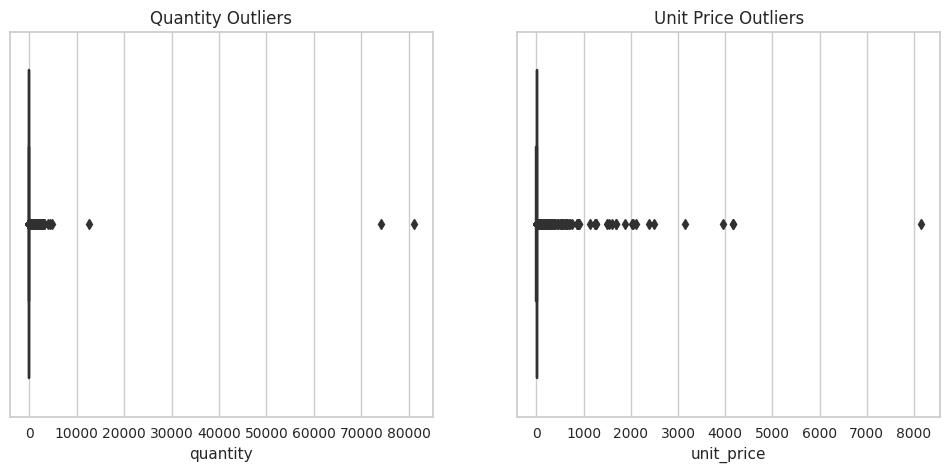

In [16]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v4['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v4['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [17]:
# Define function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from quantity and unit price
df_v5 = remove_outliers(df_v4, 'quantity')
df_v6 = remove_outliers(df_v5, 'unit_price')


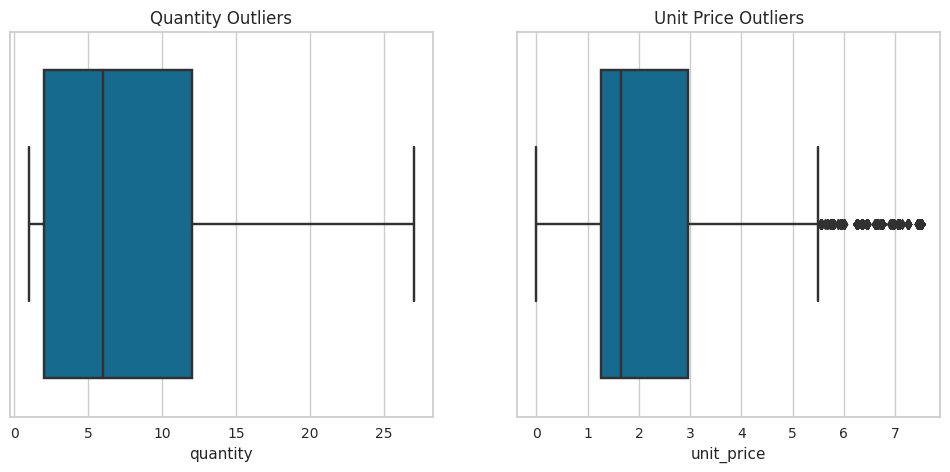

In [18]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v6['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v6['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [19]:
df_v6.shape

(333265, 8)

### RFMT


In [20]:
df_v7 = df_v6.copy()
df_v7['total'] = df_v6['quantity'] * df_v6['unit_price']

In [21]:
latest_date = df_v7['invoice_date'].max()

# Create RFM features and Shopping Cycle
RFM = df_v7.groupby('customer_id').agg(
    Recency=('invoice_date', lambda x: (latest_date - x.max()).days),
    Frequency=('invoice_no', 'nunique'),
    Monetary=('total', 'sum'),
    Tenure=('invoice_date', lambda x: (x.max() - x.min()).days)
)

# Calculate Interpurchase Time
RFM['Interpurchase_Time'] = RFM['Tenure'] / RFM['Frequency']

# Create RFMT dataframe with required features
RFMT = RFM[['Recency', 'Frequency', 'Monetary', 'Interpurchase_Time']]


RFMT.head()

,Recency,Frequency,Monetary,Interpurchase_Time
customer_id,,,,
12347,1,7,3314.73,52.142857
12348,248,3,90.2,36.333333
12349,18,1,999.15,0.000000
12350,309,1,294.4,0.000000
12352,35,7,1130.94,37.142857


### Customer Segmentation

In [22]:
# Standardizing the RFMT data
scaler = StandardScaler()
rfmt_scaled = scaler.fit_transform(RFMT)


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run1 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run2 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run3 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run4 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run5 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run6 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run7 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run8 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-kmeans-20241013-run9 to Experiment: retail-experiment-autolog


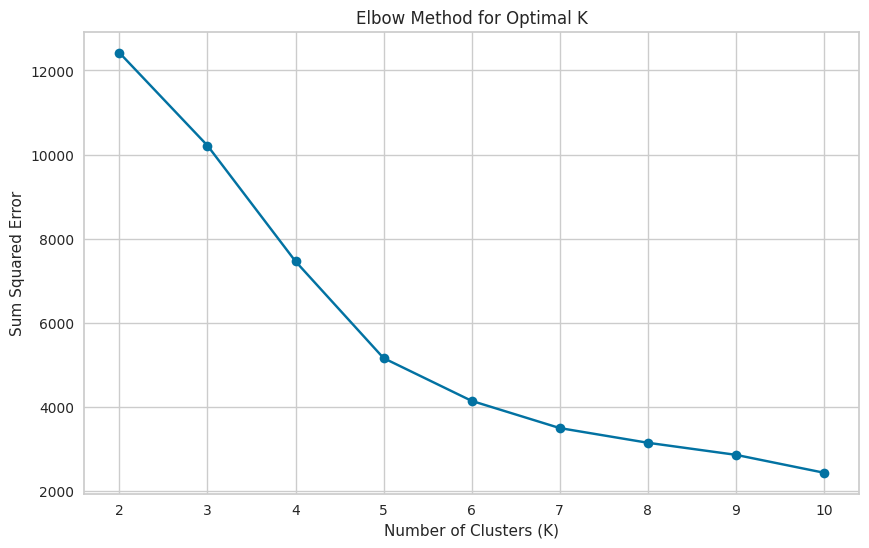

In [23]:
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

#with vertex_ai.start_run(run="run-1"):
sse = []
metrics = {}
params = {}

for k in range(2, 11):
    with vertex_ai.start_run(run=f"kmeans-{today}-run{k-1}"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(rfmt_scaled)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(rfmt_scaled, kmeans.labels_)

        metrics["inertia"] = kmeans.inertia_
        metrics["silhouette_score"] = silhouette_avg
        params["n_clusters"] = kmeans.n_clusters

        vertex_ai.log_metrics(metrics) # Log metrics
        vertex_ai.log_params(params) # Log model parameters  
           

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum Squared Error')
plt.title('Elbow Method for Optimal K')
plt.show()


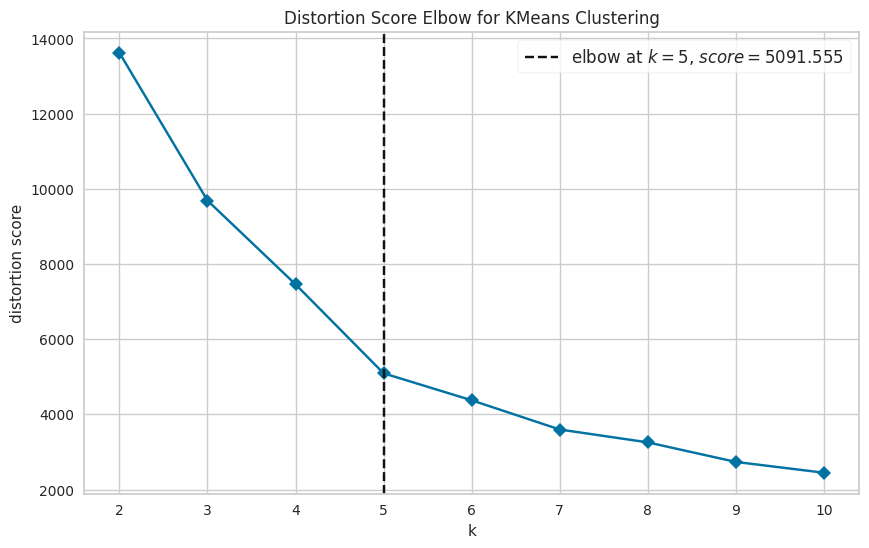

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
# Finding initial K value using Elbow Method
plt.figure(figsize=(10,6))
Elbow_M = KElbowVisualizer(KMeans(), k=10, timings=False, random_state=42) 
Elbow_M.fit(rfmt_scaled)
Elbow_M.show()

In [25]:
kmeans = KMeans(n_clusters=5, random_state=42)
RFMT['Cluster'] = kmeans.fit_predict(rfmt_scaled)

In [26]:
print("Silhouette Score",silhouette_score(rfmt_scaled, kmeans.labels_, metric='euclidean'))

Silhouette Score 0.42302619615034603


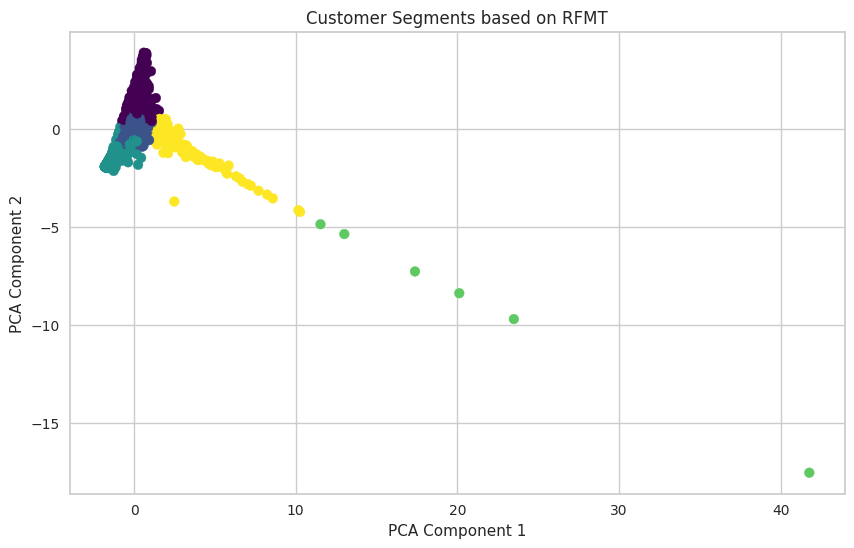

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfmt_pca = pca.fit_transform(rfmt_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_pca[:, 0], rfmt_pca[:, 1], c=RFMT['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments based on RFMT')
plt.show()


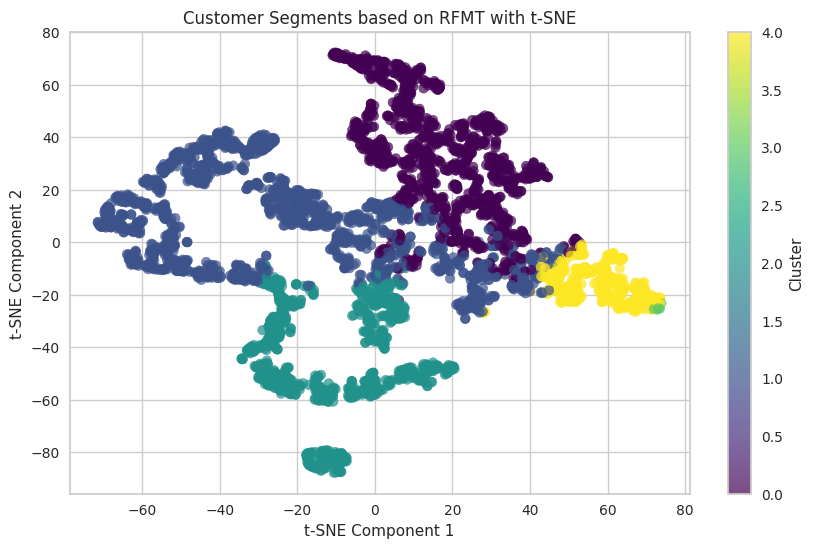

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
rfmt_tsne = tsne.fit_transform(rfmt_scaled)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_tsne[:, 0], rfmt_tsne[:, 1], c=RFMT['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Customer Segments based on RFMT with t-SNE')
plt.colorbar(label='Cluster')
plt.show()


In [29]:
cluster_analysis = RFMT.groupby('Cluster').mean()
print(cluster_analysis)

            Recency   Frequency      Monetary  Interpurchase_Time
Cluster                                                          
0         47.231013    3.667722    947.043972           74.218669
1         48.805813    2.682746    612.725932           12.281807
2        255.433440    1.443024    291.014389            6.629273
3          1.166667  116.833333  37967.673333            3.531138
4         13.431694   15.860656   4400.454153           24.581588


In [38]:
# Upload the kmeans model to Model Registry
kmeans_model_artifact_path = "/home/jupyter/models/kmeans/"
kmeans_display_name = "Kmeans_Model"

kmeans_vertex_model = vertex_ai.Model.upload(
    display_name=kmeans_display_name,
    artifact_uri=os.path.join(os.getcwd(), kmeans_model_artifact_path),
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
)

print(f"Kmeans Model uploaded to Vertex AI: {kmeans_vertex_model.resource_name}")

Creating Model
Create Model backing LRO: projects/456146517905/locations/europe-central2/models/1434378889131458560/operations/5974496596195278848
Model created. Resource name: projects/456146517905/locations/europe-central2/models/1434378889131458560@1
To use this Model in another session:
model = aiplatform.Model('projects/456146517905/locations/europe-central2/models/1434378889131458560@1')
Kmeans Model uploaded to Vertex AI: projects/456146517905/locations/europe-central2/models/1434378889131458560


### **Clusters Interpretation**:
- **Cluster 0**: 
   - Moderate recency and frequency.
   - Moderate monetary value.
   - Larger interpurchase time. 
> Infrequent high-spenders.
- **Cluster 1**:
   - Moderate recency and frequency.
   - Low monetary value.
   - Average interpurchase time. 
> indicating somewhat engaged customers.
- **Cluster 2**:
   - High recency.
   - low frequency and low monetary value.
> Inactive customers or churned.
- **Cluster 3**:
   - Very recent purchases, high frequency and  high monetary value.
> highly engaged, high-value customers.
- **Cluster 4**:
   - Fair recency and frequency, with decent monetary value.
> moderately engaged, valuable customers.

### Marketing Strategy
- **Cluster 0 & 1**: promotional offers to increase frequency, such as discounts on next purchases within defined time frame.
- **Cluster 2**: Win-back campaigns to re-engage, send personalized emails.
- **Cluster 3**: Loyalty programs or exclusive offers for retention.
- **Cluster 4**: Cross/prior purchases recommendations.